In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import collections

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [6]:
len(all_codones)

972054

In [7]:

def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

# I've added sorting by frequency
def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    count = collections.Counter(flat_codones).most_common()
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [8]:
dictionary = make_dictionary(all_codones)

In [9]:
len(dictionary)

9424

In [10]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [11]:
######################

In [12]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding='SAME', name=name)

In [13]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_matrix(self):
        with tf.name_scope("matrix"):
            self.embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size,
                                                               self.embed_size], -1.0, 1.0),
                                            name='matrix')

    def _create_conv_layer(self):
        with tf.name_scope("conv"):
            W_conv = weight_variable([1, 1, 1, 1], name='W_conv')
            b_conv = bias_variable([1], name='b_conv')
            x = tf.reshape(self.matrix, [-1, self.vocab_size, self.embed_size, 1]) 
            conv = conv2d(x, W_conv, name='Conv2D')
            self.embed_matrix = tf.reshape(conv, [self.vocab_size, self.embed_size], 
                                           name='conv_reshaped')
            
    def _create_loss(self):
        with tf.name_scope("loss"):
            
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss,
                                                                                 global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_matrix()
        #self._create_conv_layer()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [14]:
VOCAB_SIZE = len(dictionary)
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 7  # Number of negative examples to sample.
LEARNING_RATE = .5
NUM_TRAIN_STEPS = 1500000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [15]:
######################

In [16]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [53]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)

def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        saver = tf.train.Saver()
        save_dir = 'checkpoints_copy'

        try:
            print("Trying to restore last checkpoint ...")
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
            saver.restore(session, save_path=last_chk_path)
            print("Restored checkpoint from:", last_chk_path)
        except:
            print("Failed to restore checkpoint. Initializing variables instead.")
            session.run(tf.global_variables_initializer())
        
        return
        
        #sess.run(tf.global_variables_initializer())
        #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
        #print(ckpt)
        #print(os.path.isfile(ckpt.model_checkpoint_path))
#         if that checkpoint exists, restore from checkpoint
        #if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
        #    model.saver.restore(sess, ckpt.model_checkpoint_path)
        #return

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary, cur_matrix = sess.run([model.loss, model.optimizer, model.summary_op, model.embed_matrix],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                #print('Cur matrix 100th row', cur_matrix[100])
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [18]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999:  24.8
Average loss at step 3999:  19.1
Average loss at step 5999:  15.0
Average loss at step 7999:  13.6
Average loss at step 9999:   9.9
Average loss at step 11999:   9.4
Average loss at step 13999:   6.3
Average loss at step 15999:   8.4
Average loss at step 17999:   6.8
Average loss at step 19999:   6.4
Average loss at step 21999:   5.9
Average loss at step 23999:   5.3
Average loss at step 25999:   4.9
Average loss at step 27999:   4.2
Average loss at step 29999:   3.9
Average loss at step 31999:   4.0
Average loss at step 33999:   3.8
Average loss at step 35999:   2.6
Average loss at step 37999:   3.6
Average loss at step 39999:   3.5
Average loss at step 41999:   3.3
Average loss at step 43999:   3.4
Average loss at step 45999:   2.8
Average loss at step 47999:   3.1
Average loss at step 49999:   3.0
Average loss at step 51999:   2.4
Average loss at step 53999:   2.4
Average loss at step 55999:   2.0
Average loss at step 57999:   2.8
Average loss at ste

Average loss at step 473999:   2.5
Average loss at step 475999:   2.2
Average loss at step 477999:   2.0
Average loss at step 479999:   2.6
Average loss at step 481999:   2.4
Average loss at step 483999:   2.0
Average loss at step 485999:   2.7
Average loss at step 487999:   2.4
Average loss at step 489999:   2.2
Average loss at step 491999:   2.2
Average loss at step 493999:   2.1
Average loss at step 495999:   2.2
Average loss at step 497999:   2.4
Average loss at step 499999:   2.5
Average loss at step 501999:   2.0
Average loss at step 503999:   1.9
Average loss at step 505999:   2.6
Average loss at step 507999:   2.3
Average loss at step 509999:   2.4
Average loss at step 511999:   2.4
Average loss at step 513999:   2.4
Average loss at step 515999:   2.2
Average loss at step 517999:   2.2
Average loss at step 519999:   2.4
Average loss at step 521999:   2.1
Average loss at step 523999:   2.3
Average loss at step 525999:   2.5
Average loss at step 527999:   2.5
Average loss at step

Average loss at step 943999:   1.2
Average loss at step 945999:   1.0
Average loss at step 947999:   1.2
Average loss at step 949999:   1.1
Average loss at step 951999:   1.4
Average loss at step 953999:   1.4
Average loss at step 955999:   2.9
Average loss at step 957999:   2.7
Average loss at step 959999:   2.6
Average loss at step 961999:   2.7
Average loss at step 963999:   2.4
Average loss at step 965999:   2.3
Average loss at step 967999:   2.6
Average loss at step 969999:   2.6
Average loss at step 971999:   2.5
Average loss at step 973999:   2.4
Average loss at step 975999:   2.3
Average loss at step 977999:   2.4
Average loss at step 979999:   2.3
Average loss at step 981999:   2.3
Average loss at step 983999:   1.9
Average loss at step 985999:   2.3
Average loss at step 987999:   2.3
Average loss at step 989999:   2.6
Average loss at step 991999:   2.6
Average loss at step 993999:   2.5
Average loss at step 995999:   2.6
Average loss at step 997999:   2.5
Average loss at step

Average loss at step 1401999:   2.6
Average loss at step 1403999:   2.3
Average loss at step 1405999:   2.3
Average loss at step 1407999:   2.2
Average loss at step 1409999:   2.2
Average loss at step 1411999:   2.2
Average loss at step 1413999:   2.0
Average loss at step 1415999:   2.2
Average loss at step 1417999:   2.1
Average loss at step 1419999:   2.7
Average loss at step 1421999:   2.5
Average loss at step 1423999:   2.4
Average loss at step 1425999:   2.6
Average loss at step 1427999:   2.6
Average loss at step 1429999:   2.6
Average loss at step 1431999:   2.0
Average loss at step 1433999:   1.8
Average loss at step 1435999:   2.4
Average loss at step 1437999:   2.7
Average loss at step 1439999:   2.7
Average loss at step 1441999:   2.4
Average loss at step 1443999:   2.3
Average loss at step 1445999:   2.1
Average loss at step 1447999:   2.1
Average loss at step 1449999:   2.1
Average loss at step 1451999:   2.0
Average loss at step 1453999:   2.1
Average loss at step 1455999

In [19]:
final_embed_matrix

array([[-0.1788726 ,  0.06352279,  0.20417669, ..., -0.07852899,
        -0.15395242, -0.19479749],
       [-0.14539281,  0.15225504,  0.1984829 , ...,  0.12135678,
        -0.02620173,  0.35002044],
       [ 0.14615406, -0.1313851 , -0.26296726, ..., -0.50978965,
         0.14209567,  0.23275888],
       ..., 
       [-0.35499239,  0.92123199,  0.20749044, ...,  0.96454573,
        -0.46314907, -0.59946823],
       [-0.93901634, -0.12750483, -0.81264901, ..., -0.85041928,
        -0.41288972,  0.9166038 ],
       [ 0.66656709, -0.34473491,  0.47611141, ...,  0.71734643,
        -0.52254581,  0.75010371]], dtype=float32)

In [20]:
final_embed_matrix[110]

array([-0.05808124, -0.2702741 ,  0.23374355,  0.03329588,  0.28464177,
       -0.18135138, -0.27312088, -0.0792769 ,  0.06765673,  0.19695969,
        0.30224526, -0.43541247,  0.20541178,  0.05715238,  0.418706  ,
        0.33900061, -0.29642683, -0.28246671,  0.30710667,  0.34872133,
       -0.03053589, -0.25851986, -0.33247155, -0.27733579, -0.03450498,
       -0.16856   ,  0.33631071, -0.25987461,  0.27384746,  0.29659611,
        0.13111487,  0.21963502, -0.20245473, -0.26549467,  0.38368383,
        0.1618522 , -0.02639238, -0.34695369,  0.0803695 ,  0.22643267,
       -0.04453176,  0.28512827,  0.35255834, -0.0803884 ,  0.02346297,
        0.14236982,  0.28951535, -0.11098605,  0.25529975, -0.19437127,
       -0.21824153, -0.05479385,  0.0009965 ,  0.27405843, -0.06208887,
       -0.21950285, -0.44743136,  0.06627847, -0.09608825,  0.19581346,
        0.2664412 , -0.02507019, -0.22346064, -0.09773409,  0.1966729 ,
        0.33563221, -0.05667553, -0.06290171, -0.34061858, -0.03

In [21]:
######################

In [22]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [23]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-2.772461,-7.154655,AAA
1,-0.867646,0.684946,LLL
2,3.345885,2.249863,ALA
3,-1.151602,-6.515843,LAA
4,-2.337872,-3.876973,AAL


In [24]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [25]:
######################

In [26]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [27]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

all_acid_df = pd.DataFrame(all_acid_dicts)
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')

reading data/all_acid_dicts.pickle


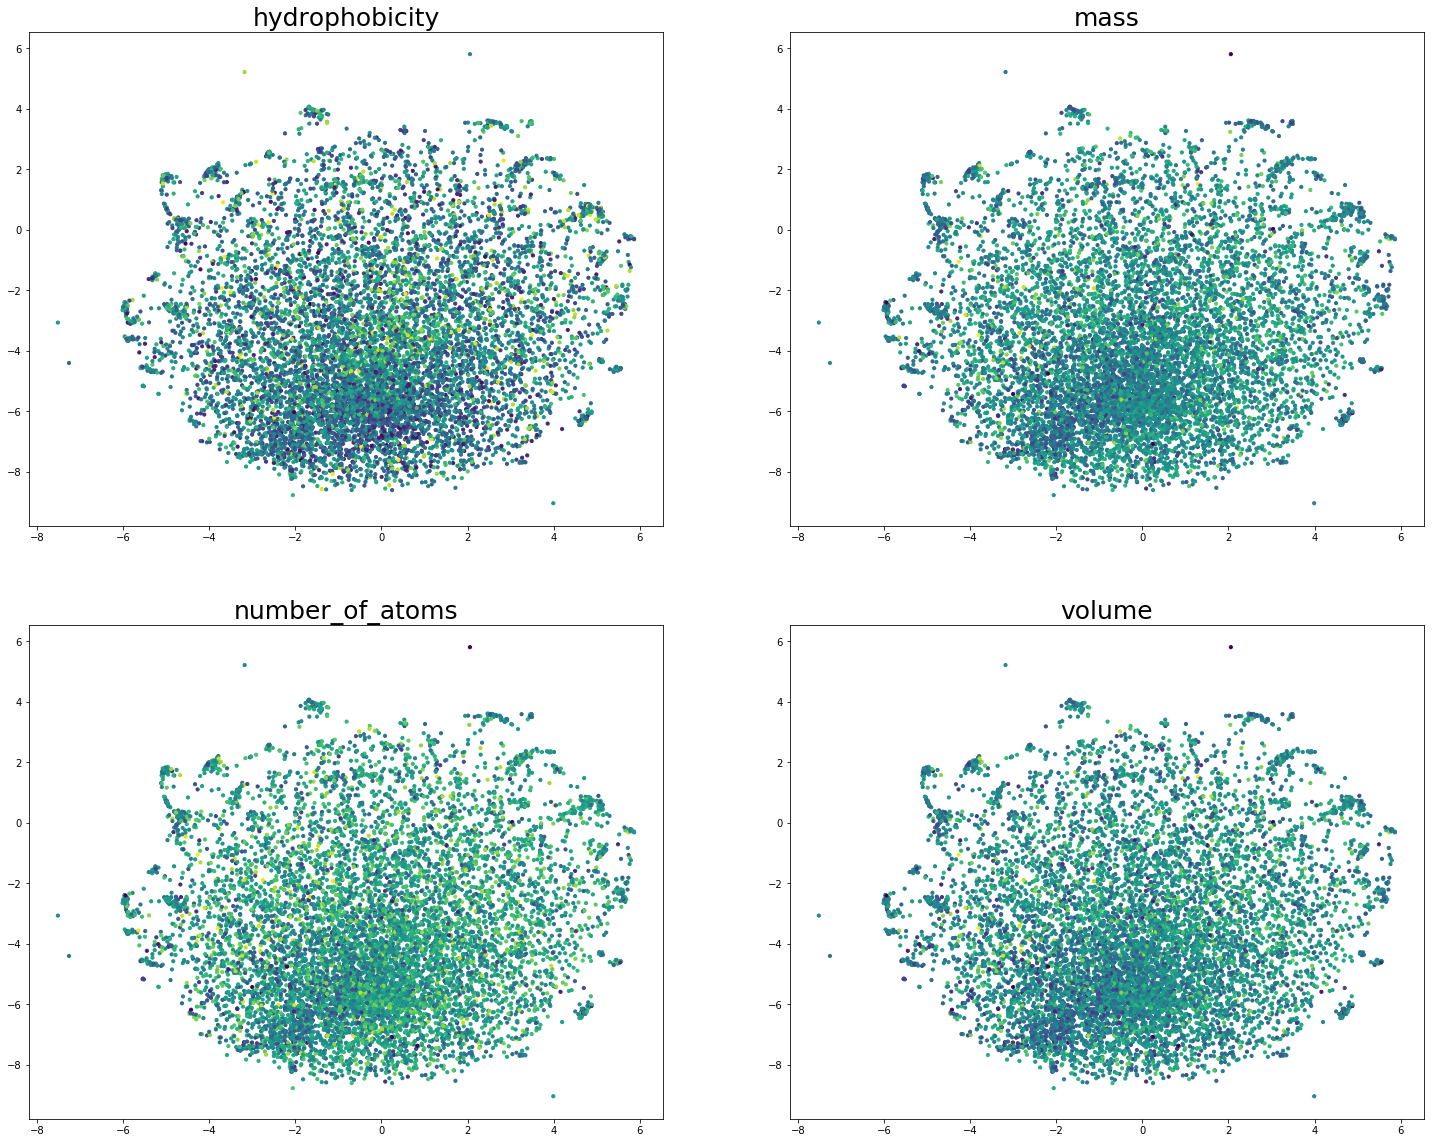

In [31]:
def plot_embedding_properties(final_df, save=False):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    if save:
        plt.savefig('hw_pure.png')
    else:
        plt.show()

plot_embedding_properties(final_df)